In [51]:
from ansys.mapdl.core import launch_mapdl
import pandas as pd

def launch_mapdl_on_available_port(starting_port=50052, max_attempts=5):
    for i in range(max_attempts):
        port = starting_port + i
        try:
            mapdl = launch_mapdl(port=port)
            print(f"MAPDL launched successfully on port {port}")
            return mapdl
        except Exception as e:
            print(f"Failed to launch MAPDL on port {port}: {e}")
    raise RuntimeError("Could not launch MAPDL on any available port")

# Use a função para iniciar uma instância do MAPDL
mapdl = launch_mapdl_on_available_port()

MAPDL launched successfully on port 50052


In [3]:
import math
import numpy as np 

# Definindo variáveis apenas uma vez
raio_estaca = 0.5
distancia_minima = raio_estaca * 2.5  # 5 vezes o raio da estaca
largura = 6
altura = 3
n_estacas = 2
n_estacas_centrais = round(1) 
L_estacas=20

#FUNÇÕES AUXILIARES
def round_to_nearest(value, targets=[0, 0.333, 0.666, 1]): #Arrendonda o valor de angulo vertical para o valor mais próximo a fim de trabalhar dentro de limites construtivos de equipamento e também trabalhar com um menor espaço amostral                    
    return min(targets, key=lambda t: abs(value - t))

def distancia_entre_pontos(p1, p2): #Mede a distancia entre pontos a fim de assegurar limites geométricos da estrutura
    return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

def espelhar_pontos(coordinates, n_estacas_centrais): 
    espelho = [(x, -y, z) for x, y, z in coordinates[:-int(n_estacas_centrais)]]
    return espelho

def converter_x(x_normalizado): #Converte os valores do de interesse em coordenadas "X"
    return raio_estaca + x_normalizado * (largura-2*raio_estaca)

def converter_y(y_normalizado): #Converte os valores do de interesse em coordenadas "Y"
    return raio_estaca + y_normalizado * (altura-2*raio_estaca)

def converter_angulos_verticais(array_angulos_verticais): #Converte os valores do de interesse em angulos trigonométricos
    return [np.round(75 + 15 * ang_v, 2) for ang_v in array_angulos_verticais]

def converter_angulos_horizontais(array_angulos_horizontais): #Converte os valores do de interesse em angulos trigonométricos
    return [np.round(46 + 268 * ang_h, 2) for ang_h in array_angulos_horizontais]

def spherical_to_cartesian(x_inicial, y_inicial, z_inicial, L_estacas, angulos_verticais_theta, angulos_horizontais_theta): #Converte os valores do de interesse em coordendas cartesianas
    angulo_vertical_rad = np.deg2rad(angulos_verticais_theta)
    angulo_horizontal_rad = np.deg2rad(angulos_horizontais_theta)
    
    componente_x = L_estacas * np.cos(angulo_vertical_rad) * np.cos(angulo_horizontal_rad)
    componente_y = L_estacas * np.cos(angulo_vertical_rad) * np.sin(angulo_horizontal_rad)
    componente_z = L_estacas * np.sin(angulo_vertical_rad)
    
    x_final = x_inicial + componente_x
    y_final = y_inicial + componente_y
    z_final = z_inicial + componente_z

    return x_final, y_final, z_final

def gerar_pontos_finais(pontos, angulos_verticais_theta, angulos_horizontais_theta): #Gera pontos finais
    coordenadas_finais = []
    for i in range(len(pontos)):
        x, y, z = pontos[i]
        theta_v, theta_h = angulos_verticais_theta[i], angulos_horizontais_theta[i]
        x_final, y_final, z_final = spherical_to_cartesian(x, y, z, L_estacas, theta_v, theta_h)
        coordenadas_finais.append((round(x_final, 2), round(y_final, 2), -1*round(z_final, 2)))
    return coordenadas_finais

def espelhar_pontos_finais(pontos, k):
    espelho = []
    for (x, y, z) in pontos[:-k]:
        y_espelhado = -y
        espelho.append((x, y_espelhado, z))
    return espelho

def distancia_entre_pontos_r3(p1, p2): #Garante limites geométricos/normatívos da estrutura
    return round(np.linalg.norm(p1 - p2), 2)

def encontrar_menor_distancia_entre_vetores(pontos_iniciais, pontos_finais, k, l, comprimento): #Garante limites geométricos/normatívos da estrutura
    vetor_k = pontos_finais[k] - pontos_iniciais[k]
    vetor_l = pontos_finais[l] - pontos_iniciais[l]

    vetor_dividido_k = vetor_k / comprimento
    vetor_dividido_l = vetor_l / comprimento

    menor_distancia = float('inf')
    ponto_menor_distancia_v1 = None
    ponto_menor_distancia_v2 = None
    N_v1 = None
    N_v2 = None

    for N1 in np.arange(1, 19, 1):
        for N2 in np.arange(1, 19, 1):
            ponto_v1 = pontos_iniciais[k] + N1 * vetor_dividido_k
            ponto_v2 = pontos_iniciais[l] + N2 * vetor_dividido_l

            dist = round(distancia_entre_pontos_r3(ponto_v1, ponto_v2), 2)

            if dist < menor_distancia:
                menor_distancia = dist
                ponto_menor_distancia_v1 = ponto_v1
                ponto_menor_distancia_v2 = ponto_v2
                N_v1 = N1
                N_v2 = N2

    return menor_distancia, ponto_menor_distancia_v1, ponto_menor_distancia_v2, N_v1, N_v2

def gerar_lista_k(array_angulos_verticais, n_estacas, n_estacas_centrais): #Gera lista auxiliar
    indices = list(range(len(array_angulos_verticais)))
    indices_menores = sorted(range(len(array_angulos_verticais) - 1), key=lambda i: array_angulos_verticais[i])[:n_estacas]
    lista_k = [i for i in indices_menores]
    lista_k.append(2)
    if len(lista_k) < n_estacas + n_estacas_centrais and lista_k.count(2) < 2:
        lista_k.append(2)
    return lista_k

#Garante limites geométricos/normatívos da estrutura, tentando otimizar brevemente a estrutura, caso não seja possível, penaliza ela
def verificar_e_ajustar_pontos(pontos, L_estacas, distancia_minima, pontos_finais, array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos, array_angulos_horizontais,p):
    max_iteracoes=1*(n_estacas+n_estacas_centrais+n_estacas)
    iteracao = 0
    pontos_finais = np.array(pontos_finais)
    incremento = 0.05
    print("P antes do ajuste(Punição de estacas iniciais somente)",p)
    lista_k = gerar_lista_k(array_angulos_verticais_convertidos, n_estacas, n_estacas_centrais)
    trial=5

    for k in lista_k:
        while iteracao <= max_iteracoes:
            ajustou_ponto = False

            for l in range(len(pontos_finais)):
                if k == l:
                    continue
                ponto1 = pontos_finais[k]
                ponto2 = pontos_finais[l]
                dist = distancia_entre_pontos_r3(ponto1, ponto2)
                menor_distancia, _, _, _, _ = encontrar_menor_distancia_entre_vetores(pontos, pontos_finais, k, l, L_estacas)
                if menor_distancia < 3 * raio_estaca or dist < 5 * raio_estaca:
                    ajustou_ponto = True
                    if k <= n_estacas:
                        array_angulos_horizontais_convertidos[k] = np.round(array_angulos_horizontais_convertidos[k]+incremento,2)
                        array_angulos_horizontais[k] = np.round(array_angulos_horizontais[k]+incremento,2)
                    else:
                        # Alterna entre 0/180 e 0/1 usando (-1)**trial
                        if (-1) ** trial == 1:
                            array_angulos_horizontais_convertidos[k] = 180
                            array_angulos_horizontais[k] = 1
                        else:
                            array_angulos_horizontais_convertidos[k] = 0
                            array_angulos_horizontais[k] = 0

                    x_novo, y_novo, z_novo = spherical_to_cartesian(
                        pontos[k][0], pontos[k][1], pontos[k][2],
                        L_estacas, array_angulos_verticais_convertidos[k], array_angulos_horizontais_convertidos[k]
                    )
                    x = np.round(x_novo, 2)
                    y = np.round(y_novo, 2)
                    z = -1*np.round(z_novo, 2)

                    if k < n_estacas:
                        pontos_finais[k, :] = [x, y, z]
                        pontos_finais[k + n_estacas + n_estacas_centrais, :] = [x, -y, z]
                    else:
                        pontos_finais[k, :] = [x, y, z]
                    break

            if not ajustou_ponto:
                break
            trial += 1
            
            if trial >= max_iteracoes:
                p+= ((3 * raio_estaca)/(0.1+menor_distancia)+(5 * raio_estaca)/(0.1+dist))*10**4

                print("P em cada iteração",p)
                k+=1
                iteracao+=1

                break

    return pontos_finais, array_angulos_horizontais_convertidos, array_angulos_horizontais,p

def analise(pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais):#Analise estrutural dentro do ansys
    mapdl.clear('NOSTART')
    mapdl.prep7()

    # Título
    mapdl.title('Análise de Estacas e Casca')

    # Definir o tipo de elemento (BEAM188) e suas propriedades
    mapdl.et(1, 'BEAM188')

    # Propriedades do material
    modulo_elasticidade = 0.85 * 5600 * (40 ** 0.5) * 1e6  # N/m²
    mapdl.mp('EX', 1, modulo_elasticidade)
    mapdl.mp('PRXY', 1, 0.2)  # Coeficiente de Poisson
    mapdl.mp('DENS', 1, 2500)  # Densidade

    # Propriedades da seção da viga
    mapdl.sectype(1, 'BEAM', 'CSOLID')
    mapdl.secoffset('CENT')
    mapdl.secdata(0.5)

    # Número de nós intermediários
    num_intermediate_nodes = 9

    # Adicionar nós
    node_id = 1
    for i in range(2 * n_estacas + n_estacas_centrais):
        # Obter coordenadas iniciais e finais
        x_inicial, y_inicial, z_inicial = pontos_iniciais[i]
        x_final, y_final, z_final = pontos_finais_ajustados[i]

        # Criar o nó inicial
        mapdl.n(node_id, x_inicial, y_inicial, z_inicial)

        # Definir o ID do nó final
        node_id_final = node_id + num_intermediate_nodes + 1

        # Criar o nó final
        mapdl.n(node_id_final, x_final, y_final, z_final)

        # Travar o nó final
        mapdl.d(node_id_final, 'ALL', 0)

        # Preencher nós intermediários
        mapdl.fill(node_id, node_id_final, num_intermediate_nodes)

        # Atualizar o próximo node_id
        node_id = node_id_final + 1

    # Geração de elementos
    n_elemento = 1
    for i in range(2 * n_estacas + n_estacas_centrais):
        for j in range(1, num_intermediate_nodes + 2):
            N_1 = j + (num_intermediate_nodes + 2) * i
            N_2 = N_1 + 1
            mapdl.en(n_elemento, N_1, N_2)
            n_elemento += 1

    # Selecionar elementos tipo BEAM188
    mapdl.esel('S', 'TYPE', '', 1)

    # Contar elementos selecionados
    num_elem = mapdl.get('num_elem', 'ELEM', 0, 'COUNT')
    k = num_elem

    # Criar elemento de carga
    mapdl.n(1000, 3, 0, 0)
    mapdl.n(1001, 3, 0, 0.1)
    mapdl.en(k + 1, 1000, 1001)

    # Definir tipo de elemento SHELL181
    mapdl.et(2, 'SHELL181')
    mapdl.keyopt(2, 8, 2)  # Elastoplástico
    mapdl.keyopt(2, 3, 2)  # Precisão de tensões

    # Propriedades do material para SHELL181
    modulo_elasticidade_shell = 0.85 * 5600 * (20 ** 0.5) * 1e6
    mapdl.mp('EX', 2, modulo_elasticidade_shell)
    mapdl.mp('PRXY', 2, 0.2)
    mapdl.mp('DENS', 2, 2500)

    # Definir seção de casca
    mapdl.sectype(2, 'SHELL')
    mapdl.secdata(1.5)

    # Criar retângulo e malhar
    mapdl.rectng(0, 6, -3, 3)
    mapdl.esize(0.1)
    mapdl.amesh('ALL')

    # Selecionar elementos tipo SHELL181
    mapdl.esel('S', 'TYPE', '', 2)
    mapdl.emodif('ALL', 'SECNUM', 2)

    # Merge de nós
    mapdl.nsel('S', 'LOC', 'Z', 0, 1e5)
    mapdl.nummrg('NODE', 1e-5)
    mapdl.nsel('ALL')

    # Saída dos resultados
    mapdl.allsel('ALL')

    # Aplicar gravidade
    mapdl.acel(0, 0, -9.81)

    # Finalizar
    mapdl.finish()

    # Entrar no modo de solução
    mapdl.slashsolu()
    mapdl.antype(0)

    import math

    # Definir a força aplicada e o número de load steps
    f = 1000000  # Força de 1 milhão de N
    casos = 12  # Definir loadsteps

    # Loop para aplicar as diferentes condições de carga (12 casos de 15 em 15 graus)
    for i in range(1, casos + 2):
        Rad = (i - 1) * (180 / casos) * math.pi / 180  # Variação de 15 graus

        # Calcular as componentes da força horizontal
        FX = math.cos(Rad) * f
        FY = math.sin(Rad) * f

        # Selecionar todos os elementos
        mapdl.allsel('ALL')

        # Aplicar as forças horizontais no nó 1001
        mapdl.f(1001, 'FX', FX)
        mapdl.f(1001, 'FY', FY)

        # Resolver o modelo
        mapdl.solve()

        # Salvar os resultados da solução
        mapdl.save(f'load_step_{i}')

    # Finalizar a análise
    mapdl.finish()

    # Definir o número de casos
    casos = 12

    # Entrar no modo de pós-processamento
    mapdl.post1()

    # Definir os Load Cases para N = 12
    for i in range(1, casos + 2):
        mapdl.lcdef(i, i, 1)  # Define o Load Case i para o Load Step i

    # Carregar o primeiro Load Case
    mapdl.lcase(1)

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO MAX!!!!!!!!!!!!!!!!!!!!!
    # Comparar o Load Case 1 com os demais e armazenar os resultados (máximos)
    for R in range(2, casos + 2):
        mapdl.lcoper('MAX', R)  # Compara o Load Case na memória com os próximos
        mapdl.lcwrite(50 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(50 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('Fx_MAX', 'SMISC', 1, 'MAX')  # Força Axial máxima

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO MIN!!!!!!!!!!!!!!!!!!!!!
    # Carregar o primeiro Load Case novamente
    mapdl.lcase(1)

    # Comparar o Load Case 1 com os demais para valores mínimos
    for R in range(2, casos + 2):
        mapdl.lcoper('MIN', R)  # Compara o Load Case na memória para valores mínimos
        mapdl.lcwrite(60 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(60 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('Fx_MIN', 'SMISC', 1, 'MIN')  # Força Axial mínima

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO ABSMAX!!!!!!!!!!!!!!!!!!!!!
    # Carregar o primeiro Load Case
    mapdl.lcase(1)

    # Comparar o Load Case 1 com os demais e armazenar os resultados (máximos absolutos)
    for R in range(2, casos + 2):
        mapdl.lcoper('ABMX', R)  # Compara o Load Case na memória com os próximos
        mapdl.lcwrite(50 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(50 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('My_ABMX', 'SMISC', 2, 'ABMX')  # Momento fletor máximo em Y
    mapdl.etable('Mz_ABMX', 'SMISC', 3, 'ABMX')  # Momento fletor máximo em Z

    # Gerar ETABLE para deslocamentos dos nós selecionados
    mapdl.etable('UX', 'U', 'X')  # Deslocamento em X
    mapdl.etable('UY', 'U', 'Y')  # Deslocamento em Y
    mapdl.etable('UZ', 'U', 'Z')  # Deslocamento em Z

    mapdl.eplot()

    import pandas as pd
    import math

    # Definir a sequência de elementos
    elementos_sequencia = []
    j = 1
    for i in range(0, (2 * n_estacas) + n_estacas_centrais, 1):
        y = num_intermediate_nodes * i + j
        elementos_sequencia.append(y)
        j += 1

    # Dicionário para armazenar os resultados
    data = {
        "Fx_MAX": [],
        "Fx_MIN": [],
        "Utot": [],
        "My": [],
        "Mz": [],
        "r_max": [],
        "load_case_max": []
    }

    # Primeiro loop: Calculando Fx_MAX, Fx_MIN e Utot para cada elemento
    for elem in elementos_sequencia:
        fx_max = mapdl.get_value('ELEM', elem, 'ETABLE', 'Fx_MAX') / 1000  # kN
        fx_min = mapdl.get_value('ELEM', elem, 'ETABLE', 'Fx_MIN') / 1000  # kN
        ux = mapdl.get_value('ELEM', elem, 'ETABLE', 'UX') * 1000  # mm
        uy = mapdl.get_value('ELEM', elem, 'ETABLE', 'UY') * 1000  # mm
        uz = mapdl.get_value('ELEM', elem, 'ETABLE', 'UZ') * 1000  # mm
        Utot = math.sqrt(ux**2 + uy**2 + uz**2)

        # Adicionando os valores calculados ao dicionário
        data["Fx_MAX"].append(fx_max)
        data["Fx_MIN"].append(fx_min)
        data["Utot"].append(Utot)

    # Segundo loop: Calculando r_max, My, e Mz para cada elemento em todos os load cases
    for elem in elementos_sequencia:
        r_max_elem = 0
        my_max_elem = 0
        mz_max_elem = 0
        load_case_max = 0

        for load_case in range(1, casos + 2):
            mapdl.lcase(load_case)

            mapdl.etable('My', 'SMISC', 2)
            mapdl.etable('Mz', 'SMISC', 3)

            my_val = mapdl.get_value('ELEM', elem, 'ETABLE', 'My') / 1000
            mz_val = mapdl.get_value('ELEM', elem, 'ETABLE', 'Mz') / 1000

            r_val = math.sqrt(my_val**2 + mz_val**2)

            if r_val > r_max_elem:
                r_max_elem = r_val
                my_max_elem = my_val
                mz_max_elem = mz_val
                load_case_max = load_case

        data["My"].append(my_max_elem)
        data["Mz"].append(mz_max_elem)
        data["r_max"].append(r_max_elem)
        data["load_case_max"].append(load_case_max)

    df = pd.DataFrame(data)
    df = df.round(1)

    def f(x):
        if x <= 0:
            return 0
        elif x > 0:
            return np.exp(x)*10**7
        else:
            return np.nan

    delta1 = 5500
    delta2 = 2000
    delta3 = 2500
    delta4 = 125

    def calcular_Pt(df):
        df['Pt_Fx_MAX'] = 0.0
        df['Pt_Fx_MIN'] = 0.0
        df['Pt_r_max'] = 0.0
        df['Pt_Utot'] = 0.0

        p_total = 331350 #PESO PRÓPRIO DA ESTRUTURA

        for index, row in df.iterrows():
            if row['Fx_MAX'] > 0:
                df.at[index, 'Pt_Fx_MAX'] = f((abs(row['Fx_MAX']) - delta1) / delta1)
            else:
                df.at[index, 'Pt_Fx_MAX'] = f((abs(row['Fx_MAX']) - delta2) / delta2)

            if row['Fx_MIN'] > 0:
                df.at[index, 'Pt_Fx_MIN'] = f(((abs(row['Fx_MIN']) - delta1) / delta1))
            else:
                df.at[index, 'Pt_Fx_MIN'] = f(((abs(row['Fx_MIN']) - delta2) / delta2))

            df.at[index, 'Pt_r_max'] = f(((abs(row['r_max']) - delta3) / delta3))
            df.at[index, 'Pt_Utot'] = f(((abs(row['Utot']) - delta4) / delta4))

            p_total += (df.at[index, 'Pt_Fx_MAX'] + df.at[index, 'Pt_Fx_MIN'] +
                        df.at[index, 'Pt_r_max'] + df.at[index, 'Pt_Utot'])

        return float(p_total.round(1))

    p_total = calcular_Pt(df)
    return p_total, pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais



def objective_function(x, distancia_minima, n_estacas_centrais):#Função do projeto, compila todas as demais funções para um objetivo final
    p = 0

    x_aba_1, y_aba_1 = round(x[0], 1), round(x[1], 1)
    x_aba_2, y_aba_2 = round(x[4], 1), round(x[5], 1)
    x_central_1 = round(x[8], 1)

    x_aba_1, y_aba_1 = converter_x(x_aba_1), converter_y(y_aba_1)
    x_aba_2, y_aba_2 = converter_x(x_aba_2), converter_y(y_aba_2)
    x_central_1 = converter_x(x_central_1)

    coordinates = [
        [x_aba_1, y_aba_1, 0],
        [x_aba_2, y_aba_2, 0],
        [x_central_1, 0.0, 0.0]
    ]

    ang_v1, ang_h1 = round_to_nearest(x[2]), round_to_nearest(x[3])
    ang_v2, ang_h2 = round_to_nearest(x[6]), round_to_nearest(x[7])
    ang_v3, ang_h3 = round_to_nearest(x[9]), round_to_nearest(x[10])

    array_angulos_verticais = [ang_v1, ang_v2, ang_v3]
    array_angulos_horizontais = [ang_h1, ang_h2, ang_h3]

    array_angulos_verticais_convertidos = converter_angulos_verticais(array_angulos_verticais)
    array_angulos_horizontais_convertidos = converter_angulos_horizontais(array_angulos_horizontais)
    print("array_angulos_horizontais_convertidos ORIGINAIS",array_angulos_horizontais_convertidos)
    espelho = espelhar_pontos(coordinates, n_estacas_centrais)

    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            if distancia_entre_pontos(coordinates[i], coordinates[j]) < distancia_minima:
                p+= (distancia_minima / (0.1+distancia_entre_pontos(coordinates[i], coordinates[j]))) * 10**5

    coordenadas_finais = gerar_pontos_finais(coordinates, array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos)
    espelhos_finais = espelhar_pontos_finais(coordenadas_finais, int(n_estacas_centrais))

    pontos_iniciais = coordinates + espelho
    pontos_finais = np.array(coordenadas_finais + espelhos_finais)
    

    pontos_finais_ajustados, array_angulos_horizontais_convertidos, array_angulos_horizontais,p = verificar_e_ajustar_pontos(
    pontos_iniciais, L_estacas, distancia_minima, pontos_finais, array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos, array_angulos_horizontais,p)
    
    # Condição para realizar ou pular a análise
    if p==0:
        # Realiza a análise se p for = zero
        print("P INICIAL DEVE SER 0\nP_inicial:",p)
        # p_analise, pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais = analise(pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais)
        print("Analise feita, p é 0")
        # Atualiza p com o valor de p_analise após a análise
        p = p # + p_analise
    else:
        # Pula a análise se p for igual a zero
        print("Pula a análise, função já punida.")
    print("p depois do ajuste",p)

    return pontos_iniciais, pontos_finais_ajustados, array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos, p

# Exemplo de uso
x = [0.0, 1, 1.000, 0, 0.0, 1, 1, 0.49, 0.5, 1, 0.70490718]

pontos_iniciais, pontos_finais, array_angulos_verticais, array_angulos_horizontais, p = objective_function(x, distancia_minima, n_estacas_centrais)

resultado = {
    "Pontos Iniciais": pontos_iniciais,
    "Pontos Finais": pontos_finais,
    "Angulos Verticais Convertidos": array_angulos_verticais,
    "Angulos Horizontais Convertidos": array_angulos_horizontais,
    "p": p
}

if p > 331350:
    resultado['Penalidade'] = "Penalidade aplicada."
else:
    resultado['Penalidade'] = "Nenhuma penalidade aplicada."

resultado


array_angulos_horizontais_convertidos ORIGINAIS [46, 135.24, 224.49]
P antes do ajuste(Punição de estacas iniciais somente) 1250000.0
P em cada iteração 1650000.0
P em cada iteração 2050000.0
P INICIAL DEVE SER 0
P_inicial: 0
Analise feita, p é 0
p depois do ajuste 0


{'Pontos Iniciais': [[0.5, 2.5, 0],
  [0.5, 2.5, 0],
  [3.0, 0.0, 0.0],
  (0.5, -2.5, 0),
  (0.5, -2.5, 0)],
 'Pontos Finais': array([[  0.5,   2.5, -20. ],
        [  0.5,   2.5, -20. ],
        [  3. ,  -0. , -20. ],
        [  0.5,  -2.5, -20. ],
        [  0.5,  -2.5, -20. ]]),
 'Angulos Verticais Convertidos': [90, 90, 90],
 'Angulos Horizontais Convertidos': [46.05, 135.29, 224.49],
 'p': 0,
 'Penalidade': 'Nenhuma penalidade aplicada.'}

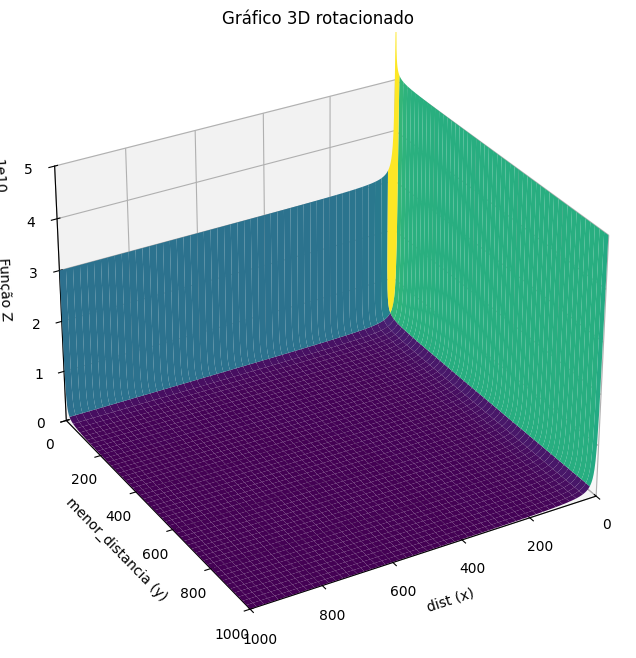

In [17]:
# Código completo para gerar o gráfico 3D com rotação e limites nos eixos, além da função Z:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parâmetros
raio_estaca = 100
x = np.linspace(1, 1000, 500)  # Variando 'dist' de 1 até 1000
y = np.linspace(1, 1000, 500)  # Variando 'menor_distancia' de 1 até 1000

# Criando a malha de valores para dist e menor_distancia
X, Y = np.meshgrid(x, y)

# Definindo a função Z
Z = ((3 * raio_estaca / Y) + (5 * raio_estaca / X)) * 10**5

# Definindo limites para os eixos
x_limits = [0, 1000]
y_limits = [0, 1000]
z_limits = [0, 5e10]  # Ajuste para o eixo z baseado na escala dos valores de Z

# Definindo os ângulos de elevação e azimute para rotacionar o gráfico
elevation = 30  # Ângulo de elevação (vertical)
azimuth = 60    # Ângulo de azimute (horizontal)

# Criando a figura para o gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotando a superfície 3D
ax.plot_surface(X, Y, Z, cmap='viridis')

# Definindo limites dos eixos
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_zlim(z_limits)

# Aplicando a rotação
ax.view_init(elevation, azimuth)

# Rótulos dos eixos
ax.set_xlabel('dist (x)')
ax.set_ylabel('menor_distancia (y)')
ax.set_zlabel('Função Z')
ax.set_title('Gráfico 3D rotacionado')

# Exibindo o gráfico
plt.show()
